In [1]:
# Install required libraries
!pip install transformers pandas sklearn

# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch

# Load the dataset
df= pd.read_csv("Reviews(13).csv")
df


,review,Label
0,I do not know how you can say he is a doctor,Negative
1,He is not a doctor. Just know how to charge money,negative
2,Alhmdulillah positive experience,positive
3,Glad to have good experience,positive
4,Fair review.,Neutral
...,...,...
24430,I booked an appointment for my friend for 12:...,Negative
24431,Not treated in a good way,Negative
24432,Doctor Noor Samad khan was a great doctor and ...,Positive
24433,I feel he is not competent in the field of sex...,Negative


In [2]:
df

,review,Label
0,I do not know how you can say he is a doctor,Negative
1,He is not a doctor. Just know how to charge money,negative
2,Alhmdulillah positive experience,positive
3,Glad to have good experience,positive
4,Fair review.,Neutral
...,...,...
24430,I booked an appointment for my friend for 12:...,Negative
24431,Not treated in a good way,Negative
24432,Doctor Noor Samad khan was a great doctor and ...,Positive
24433,I feel he is not competent in the field of sex...,Negative


In [3]:
## Correcting the spelling of one misspelled label
df['Label'] = df['Label'].str.replace('negative', 'Negative')
df['Label'] = df['Label'].str.replace('neutral', 'Neutral')
df['Label'] = df['Label'].str.replace('positive', 'Positive')
df['Label'] = df['Label'].str.replace('Netural', 'Neutral')
df['Label'] = df['Label'].str.replace(' Neutral', 'Neutral')

df['Label'].unique()

df['Label'].value_counts()

Positive    11730
Negative     9109
Neutral      3596
Name: Label, dtype: int64

In [4]:
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['Label'] = df['Label'].map(label_map)

In [5]:
df['Label']

0        0
1        0
2        2
3        2
4        1
        ..
24430    0
24431    0
24432    2
24433    0
24434    0
Name: Label, Length: 24435, dtype: int64

In [6]:
# Split the data into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df["review"], df["Label"], test_size=0.2)


In [7]:
# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [8]:
# Tokenize the texts
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)


In [9]:
# Convert the labels to tensors
train_labels = torch.tensor(train_labels.tolist())
# train_labels = torch.tensor([int(label) for label in train_labels.split()])
# val_labels = torch.tensor([int(label) for label in val_labels.split()])

val_labels = torch.tensor(val_labels.tolist())


In [10]:
# Create a PyTorch dataset
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    
    def __len__(self):
        return len(self.labels)
train_dataset = ReviewsDataset(train_encodings, train_labels)
val_dataset = ReviewsDataset(val_encodings, val_labels)

In [11]:
# Load the DistilBERT model and add a classification head
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

In [12]:
# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataset)
num_warmup_steps = int(0.1 * num_training_steps)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)


C:\Users\Admin\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# Define the training loop
def train_loop(train_loader, val_loader, model, optimizer, lr_scheduler, num_epochs):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        num_train_batches = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            
            train_loss += loss.item()
            num_train_batches += 1
        
        train_loss /= num_train_batches
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            num_val_batches = 0
            num_val_correct = 0
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
                num_val_batches += 1
                num_val_correct += torch.sum(torch.argmax(outputs.logits, dim=1) == labels).item()
            
            val_loss /= num_val_batches
            val_losses.append(val_loss)
            
            val_accuracy = num_val_correct / len(val_loader.dataset)
            val_accuracies.append(val_accuracy)
            
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    return train_losses, val_losses, val_accuracies


In [14]:
# Train the model and evaluate on the test set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

train_losses, val_losses, val_accuracies = train_loop(train_loader, val_loader, model, optimizer, lr_scheduler, num_epochs)


Epoch 1, Train Loss: 0.5807, Val Loss: 0.1738, Val Acc: 0.9521
Epoch 2, Train Loss: 0.1448, Val Loss: 0.1311, Val Acc: 0.9617
Epoch 3, Train Loss: 0.1054, Val Loss: 0.1215, Val Acc: 0.9640


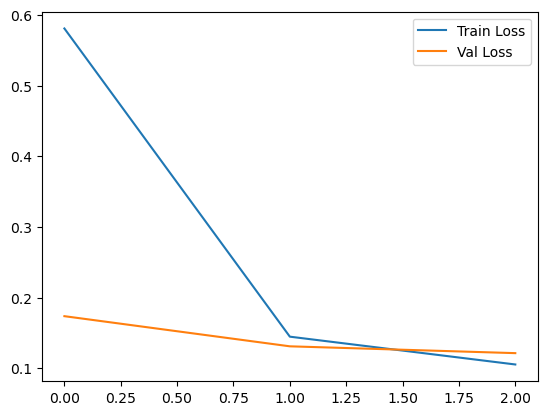

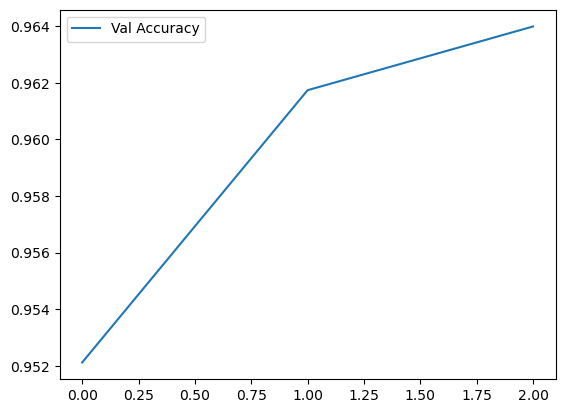

In [15]:
# Plot the loss and accuracy curves
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.show()

In [16]:

# set the model to evaluation mode
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [18]:
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set the model to evaluation mode
model.eval()

# create a dataloader for the test set
test_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# iterate over the test set and generate predictions
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = logits.argmax(axis=-1)
        predictions.extend(batch_predictions.cpu().numpy().tolist())

# print the classification report
print(classification_report(val_labels, predictions))


              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1831
           1       0.92      0.88      0.89       715
           2       0.99      0.98      0.99      2341

    accuracy                           0.96      4887
   macro avg       0.95      0.94      0.95      4887
weighted avg       0.96      0.96      0.96      4887



In [ ]:
# Make predictions on some sample reviews
sample_reviews = [
    "The doc is great, I would definitely recommend it!",
    "The doctor is terrible, I would not recommend it at all.",
    "This doctor is okay, but not worth the price."
]

model.eval()
with torch.no_grad():
    sample_encodings = tokenizer(sample_reviews, truncation=True, padding=True)
    sample_input_ids = sample_encodings['input_ids'].to(device)
    sample_attention_mask = sample_encodings['attention_mask'].to(device)
    sample_outputs = model(sample_input_ids, attention_mask=sample_attention_mask)
    sample_predictions = torch.argmax(sample_outputs.logits, dim=1).tolist()
    
    for review, prediction in zip(sample_reviews, sample_predictions):
        if prediction == 0:
            print(f"{review} \nPrediction: Negative\n")
        elif prediction == 1:
            print(f"{review} \nPrediction: Neutral\n")
        else:
            print(f"{review} \nPrediction: Positive\n")


In [34]:
torch.save(model.state_dict(), 'distilbert_model.pth')


In [ ]:
model = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', num_labels=3)
model.load_state_dict(torch.load('distilbert_model.pth'))
model.eval()
